# Generating dataset 


In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as T
from torchvision import datasets
import copy
import os
from tqdm.notebook import tqdm
import numpy as np 
np.set_printoptions(suppress=True)

import random

# Mnist with shape, global configuration perturbed
- occlusion
- top-flipped
- scrambled

References:
- https://jov.arvojournals.org/article.aspx?articleid=2777402
- https://jov.arvojournals.org/article.aspx?articleid=2777582

In [82]:
def generate_partition(img):
    h, w = 28, 28
    n_split=2

    try:
        h%n_split==0 & w%n_split==0
    except:
        print("That's not an integer number.")

    # Define the window size
    windowsize_r = int(h/n_split)
    windowsize_c = int(w/n_split)


    # Crop out the window and append to patches
    patches = []
    halves = []
    for r in range(0, h - windowsize_r+1, windowsize_r):
        half = img[r:r+windowsize_r,:]
        halves.append(half)
        for c in range(0, w - windowsize_c+1, windowsize_c):
            window = img[r:r+windowsize_r,c:c+windowsize_c]
            patches.append(window)


    # get array and randomly switch positions        
    patches_array = np.array(patches)
    rand_idx = random.sample(range(0,n_split*n_split), n_split*n_split)
    patches_random = patches_array[rand_idx]


    # get top-flipped array
    halves_array = np.array(halves)
    halves_array[0] = np.fliplr(halves_array[0])
    final_topflipped = np.vstack(halves_array)

    # combine patch images to original shape + images with original order but one patch erased
    occlusion_idx = random.sample(range(0,n_split*n_split), 1)[0]
    final_occlusion =  np.zeros_like(img)
    final_random = np.zeros_like(img)

    index = 0
    for r in range(0, w - windowsize_r+1, windowsize_r):
        for c in range(0, h - windowsize_c+1, windowsize_c):
            final_random[r:r+windowsize_r,c:c+windowsize_c] = patches_random[index]
            if index == occlusion_idx:
                final_occlusion[r:r+windowsize_r,c:c+windowsize_c] = np.zeros_like(patches_random[index])
            else:
                final_occlusion[r:r+windowsize_r,c:c+windowsize_c] = patches_array[index]
            index += 1

    #visualize
#     fig = plt.figure(figsize=(15, 80))
#     fig.add_subplot(1, 4, 1)      
#     plt.imshow(img, cmap='gray')
#     fig.add_subplot(1, 4, 2)      
#     plt.imshow(final_occlusion, cmap='gray')
#     fig.add_subplot(1, 4, 3)      
#     plt.imshow(final_topflipped, cmap='gray')
#     fig.add_subplot(1, 4, 4)      
#     plt.imshow(final_random, cmap='gray')

    return final_occlusion, final_topflipped, final_random

def get_tensorized_dataset(im_set):
    images = []
    occlusions = []
    topflipped=[]
    randoms= []

    labels = []
    for img, label in im_set:
        img = np.array(img)
        occlusion, top, random = generate_partition(img)
        images.append(img)
        occlusions.append(occlusion)
        topflipped.append(top)
        randoms.append(random)
        labels.append(label)
        
    # convert to tensor and one-hot vector
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    images_tensorized = torch.stack([T.ToTensor()(im) for im in images])
    occlusions_tensorized = torch.stack([T.ToTensor()(im) for im in occlusions])
    topflipped_tensorized = torch.stack([T.ToTensor()(im) for im in topflipped])
    randoms_tensorized = torch.stack([T.ToTensor()(im) for im in randoms])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    
    return images_tensorized, occlusions_tensorized, topflipped_tensorized, randoms_tensorized, labels_tensorized

def plot(imgs, num_rows = 1, with_orig=False, row_title=None, **imshow_kwargs):
#     if not isinstance(imgs, list):
#         raise ValueError('input images should be list form')

    num_cols = int(len(imgs)/num_rows) + (len(imgs)%num_rows > 0)
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
#     import pdb; pdb.set_trace()
    for row_idx in range(num_rows):
        for col_idx, img in enumerate(imgs[row_idx*num_cols:(row_idx+1)*num_cols]):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), cmap='gray', vmin=0, vmax=1,  **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#     if with_orig:
#         axs[0, 0].set(title='Original image')
#         axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])
    plt.show()
#     plt.tight_layout()

# load original mnist
path_save = '../data/MNIST_shape'
dataset_type = 'test'


if dataset_type == 'train':
    im_set = datasets.MNIST('../data/',train=True, download=False)
elif dataset_type == 'test':
    im_set = datasets.MNIST('../data/',train=False, download=False)

orig_images_tensorized, occlusion_images_tensorized, topflipped_images_tensorized, random_images_tensorized, orig_labels_tensorized = get_tensorized_dataset(im_set)
print(orig_images_tensorized.size())
print(occlusion_images_tensorized.size())
print(topflipped_images_tensorized.size())
print(random_images_tensorized.size())

print(orig_labels_tensorized.size())

torch.Size([10000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 10])


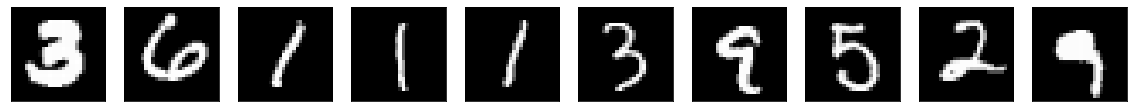

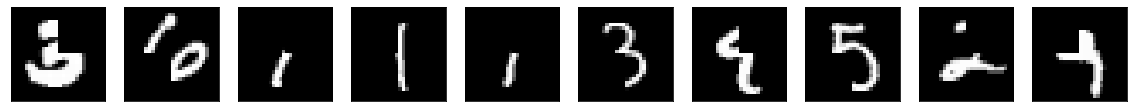

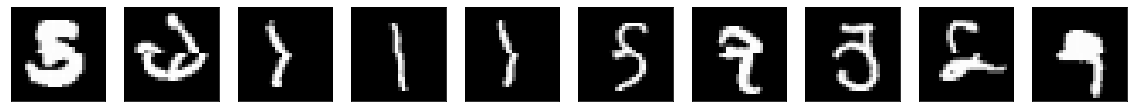

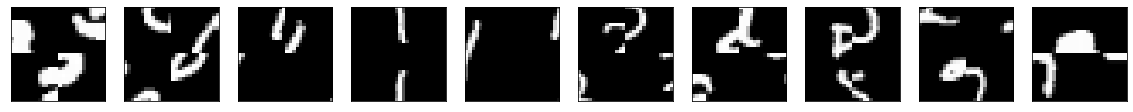

[tensor(3), tensor(6), tensor(1), tensor(1), tensor(1), tensor(3), tensor(9), tensor(5), tensor(2), tensor(9)]


In [87]:
# visualize erased images
plt.rcParams["figure.figsize"] = (20,3)
i =20#152

plottedimgs = [torch.movedim(orig_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
plottedimgs = [torch.movedim(occlusion_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
plottedimgs = [torch.movedim(topflipped_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
plottedimgs = [torch.movedim(random_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)

print([l.argmax() for l in orig_labels_tensorized[10*i:10*(i+1)]])

In [88]:
# save tensors 
# save tensors 
filename = os.path.join(path_save, f'{dataset_type}_occlusion.pt')
torch.save((occlusion_images_tensorized, orig_labels_tensorized), filename)
print(f'{filename} saved to disk')

# save tensors 
filename = os.path.join(path_save, f'{dataset_type}_flipped.pt')
torch.save((topflipped_images_tensorized, orig_labels_tensorized), filename)
print(f'{filename} saved to disk')

filename = os.path.join(path_save, f'{dataset_type}_random.pt')
torch.save((random_images_tensorized, orig_labels_tensorized), filename)
print(f'{filename} saved to disk')


../data/MNIST_shape/test_occlusion.pt saved to disk
../data/MNIST_shape/test_flipped.pt saved to disk
../data/MNIST_shape/test_random.pt saved to disk
